In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우용 한글 폰트
plt.rcParams['axes.unicode_minus'] = False  
import warnings
warnings.filterwarnings('ignore')

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 300)

# 데이터 불러오기
df = pd.read_excel('축제_데이터셋_업로드용.xlsx')  # 축제 데이터 불러오기

# 불필요한 열 제거
df1 = df.drop(columns=['시작일', '종료일', '총\n일수'])

# 예산 텍스트 처리 → 숫자형 변환
df1['예산\n(백만)'] = df1['예산\n(백만)'].replace({'미확정': 0, '무응답': 0}).astype(float)

# 거리 숫자 추출
df1['서울과거리'] = df1['서울과거리'].astype(str).str.extract(r'(\d+\.?\d*)').astype(float)

# 축제유형 정제
df1['축제유형_정리'] = df1['축제유형'].astype(str).str.replace(r'\s+', ' ', regex=True).str.replace(r'\n', ' ', regex=True).str.strip()

# 축제유형 대분류 매핑 함수 정의
def clean_type(x):
    x = x.lower()
    if '문화' in x or '예술' in x: return '문화예술'
    elif '전통' in x or '역사' in x: return '전통역사'
    elif '생태' in x or '자연' in x or '환경' in x: return '생태자연'
    elif '특산' in x or '먹거리' in x or '농산' in x or '수산' in x: return '특산물'
    elif '주민화합' in x or '시민화합' in x or '화합' in x: return '주민화합'
    elif '관광' in x: return '관광'
    elif '기타' in x: return '기타'
    elif '체험' in x: return '체험행사'
    else: return '기타'

# 대분류 컬럼 생성
df1['축제유형_대분류'] = df1['축제유형_정리'].apply(clean_type)

# 시작월로 계절 분류
df1['계절'] = df1['시작월'].map({
    12: '겨울', 1: '겨울', 2: '겨울',
    3: '봄', 4: '봄', 5: '봄',
    6: '여름', 7: '여름', 8: '여름',
    9: '가을', 10: '가을', 11: '가을'
})

# 예산 단위 환산 (백만 → 원)
df1['예산\n(백만)'] = df1['예산\n(백만)'] * 1000000

# 1인당 예산 생성
df1['1인당예산'] = df1['예산\n(백만)'] / (df1['방문객합계'] + 1)

# 장소 관련 열 → PCA로 1축 요약
place_cols = ['공원/유원지', '관광농원/허브마을', '일반관광지', '동식물원', '먹거리/패션거리',
              '산림욕장/휴향림/수목원', '폭포/계곡/호수/저수지', '해수욕장']
df1[place_cols] = df1[place_cols].fillna(0)

# PCA 객체 생성 및 학습
pca_for_saving = PCA(n_components=1) # 저장할 PCA 객체
df1['장소_PCA'] = pca_for_saving.fit_transform(df1[place_cols]) # fit_transform 수행

# 주소 기반 점수 생성 (시/군구/법정동 등장 빈도 합)
si_freq_map = df1['시'].value_counts()
gungu_freq_map = df1['군구'].value_counts()
dong_freq_map = df1['법정동'].value_counts()

# 주소 기반 점수 생성 (시/군구/법정동 등장 빈도 합)
df1['시_freq'] = df1['시'].map(si_freq_map)
df1['군구_freq'] = df1['군구'].map(gungu_freq_map)
df1['법정동_freq'] = df1['법정동'].map(dong_freq_map)
df1['주소점수'] = df1[['시_freq', '군구_freq', '법정동_freq']].sum(axis=1)

# 로그 변환 타겟 생성 (방문객합계 → log1p)
df1['방문객합계_log'] = np.log1p(df1['방문객합계'])

# 피처 설정
numeric_cols = ['예산\n(백만)', '서울과거리', '1인당예산', '장소_PCA', '주소점수']
categorical_cols = ['축제유형_대분류', '계절']

# 전처리 파이프라인 구성 (수치형: 평균대치 + 스케일링, 범주형: 최빈값 대치 + 원핫인코딩)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

# 전체 입력데이터 전처리 적용
X = df1[numeric_cols + categorical_cols]
y = df1['방문객합계_log']
X_processed = preprocessor.fit_transform(X)

# 시작년 처리
df1['시작년'] = df1['시작년'].astype(int)
X_train = X_processed[df1['시작년'] < 2024]
X_valid = X_processed[df1['시작년'] == 2024]
X_test = X_processed[df1['시작년'] == 2025]
y_train = y[df1['시작년'] < 2024]
y_valid = y[df1['시작년'] == 2024]
y_test = y[df1['시작년'] == 2025]

# 모델 학습 (Validation set을 평가에 사용)
model = XGBRegressor(random_state=42, objective='reg:squarederror')
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.1, 0.01]
}

# 최적 모델 추출
grid = GridSearchCV(model, param_grid, cv=3, scoring='r2')
grid.fit(X_train, y_train)
best_model = grid.best_estimator_

# 예측값 계산
y_train_pred = best_model.predict(X_train)
y_valid_pred = best_model.predict(X_valid)
y_test_pred = best_model.predict(X_test)

# 성능 평가 지표 계산
r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_valid = r2_score(y_valid, y_valid_pred)
mse_valid = mean_squared_error(y_valid, y_valid_pred)
rmse_valid = np.sqrt(mse_valid)


# 결과 출력
results_df = pd.DataFrame({
    'Dataset': ['Train', 'Validation'],
    'R2': [r2_train, r2_valid],
    'RMSE': [rmse_train, rmse_valid]
})

results_df

,Dataset,R2,RMSE
0,Train,0.989530,0.541669
1,Validation,0.959869,1.055592


In [9]:
import joblib
import os

output_directory = "."
os.makedirs(output_directory, exist_ok=True)

# PCA 객체 저장
pca_filename = 'pca_transformer.joblib'
pca_path = os.path.join(output_directory, pca_filename)
joblib.dump(pca_for_saving, pca_path)

# 주소 빈도 맵 저장
freq_maps_filename = 'address_freq_maps.joblib'
freq_maps_path = os.path.join(output_directory, freq_maps_filename)
joblib.dump({'si': si_freq_map, 'gungu': gungu_freq_map, 'dong': dong_freq_map}, freq_maps_path)

# 모델 저장
model_filename = 'best_model.joblib'
model_path = os.path.join(output_directory, model_filename)
joblib.dump(best_model, model_path)

# 전처리기 저장
preprocessor_filename = 'preprocessor.joblib'
preprocessor_path = os.path.join(output_directory, preprocessor_filename)
joblib.dump(preprocessor, preprocessor_path)

['.\\preprocessor.joblib']

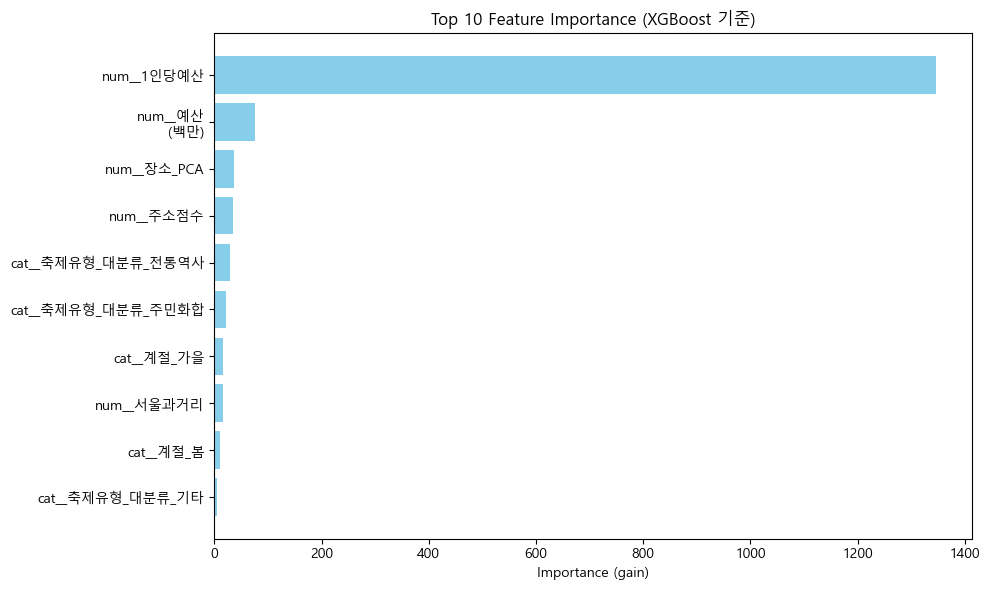

In [10]:
# 중요도 추출
booster = best_model.get_booster()
importance = booster.get_score(importance_type='gain')

# 실제 feature 이름 추출
feature_names = preprocessor.get_feature_names_out()

# f0, f1, ... 을 실제 이름으로 매핑
mapped_importance = {
    feature_names[int(k[1:])]: v for k, v in importance.items()
}

# 데이터프레임으로 정리
importance_df = pd.DataFrame({
    'Feature': list(mapped_importance.keys()),
    'Importance (gain)': list(mapped_importance.values())
}).sort_values(by='Importance (gain)', ascending=False)

# 상위 10개 중요 피처 시각화
top_features = importance_df.head(10)
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance (gain)'], color='skyblue')
plt.xlabel("Importance (gain)")
plt.title("Top 10 Feature Importance (XGBoost 기준)")
plt.gca().invert_yaxis()  # 가장 중요한 피처가 위에 오도록
plt.tight_layout()
plt.show()

In [ ]:
# 2025년 예측 예시

df1_2025 = df1[df1['시작년'] == 2025].copy()
df1_2025['예측방문객수'] = np.expm1(y_test_pred).round().astype(int)
df1_2025[['축제명', '시', '군구', '예측방문객수']].sort_values(by='예측방문객수', ascending=False).head(10)


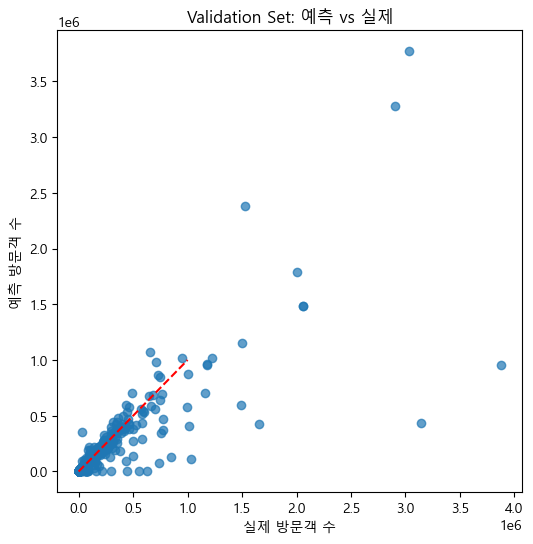

In [11]:
# 실제 빨간선 부근으로 나와있기 때문에 잘 예측했다 판단

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(np.expm1(y_valid), np.expm1(y_valid_pred), alpha=0.7)
plt.plot([0, 1e6], [0, 1e6], 'r--')
plt.xlabel("실제 방문객 수")
plt.ylabel("예측 방문객 수")
plt.title("Validation Set: 예측 vs 실제")
plt.show()


In [12]:
# 통계검정

from scipy.stats import kruskal, spearmanr, f_oneway

# 1. Kruskal-Wallis: 계절 vs 방문객수_log
groups_season = [group['방문객합계_log'].dropna() for _, group in df1.groupby('계절')]
kruskal_season_stat, kruskal_season_p = kruskal(*groups_season)

# 2. Kruskal-Wallis: 축제유형_대분류 vs 방문객수_log
groups_type = [group['방문객합계_log'].dropna() for _, group in df1.groupby('축제유형_대분류')]
kruskal_type_stat, kruskal_type_p = kruskal(*groups_type)

# 3. Spearman 상관: 1인당예산 vs 방문객합계
spearman_1 = spearmanr(df1['1인당예산'], df1['방문객합계'], nan_policy='omit')

# 4. Spearman 상관: 서울과거리 vs 방문객합계
spearman_2 = spearmanr(df1['서울과거리'], df1['방문객합계'], nan_policy='omit')

# 5. ANOVA: 시작년 vs 방문객합계_log
groups_year = [group['방문객합계_log'].dropna() for _, group in df1.groupby('시작년')]
anova_year_stat, anova_year_p = f_oneway(*groups_year)

# 결과 정리
test_results = {
    '검정': [
        'Kruskal-Wallis (계절 vs 방문객수_log)',
        'Kruskal-Wallis (축제유형_대분류 vs 방문객수_log)',
        'Spearman (1인당예산 vs 방문객합계)',
        'Spearman (서울과거리 vs 방문객합계)',
        'ANOVA (시작년 vs 방문객합계_log)'
    ],
    '통계량': [
        kruskal_season_stat,
        kruskal_type_stat,
        spearman_1.statistic,
        spearman_2.statistic,
        anova_year_stat
    ],
    'p-value': [
        kruskal_season_p,
        kruskal_type_p,
        spearman_1.pvalue,
        spearman_2.pvalue,
        anova_year_p
    ]
}

test_results_df = pd.DataFrame(test_results)
test_results_df

,검정,통계량,p-value
0,Kruskal-Wallis (계절 vs 방문객수_log),0.778600,8.545784e-01
1,Kruskal-Wallis (축제유형_대분류 vs 방문객수_log),69.590573,4.960889e-13
2,Spearman (1인당예산 vs 방문객합계),-0.863505,0.000000e+00
3,Spearman (서울과거리 vs 방문객합계),0.042341,2.123655e-03
4,ANOVA (시작년 vs 방문객합계_log),576.403516,0.000000e+00


# 예측

#### prompt

"축제데이터예측_F.ipynb"에서 best_model이 머신러닝 최적모델이며, 이 모델과 전처리 과정을 파일로 저장할거야.<br>
<br>
실제 사용자 입력은 다음과 같이 입력이 될거야.<br>

1. 시
2. 군구
3. 법정동
4. 축제유형
5. 시작년
6. 시작월
7. 예산(백만)

이 입력데이터는 모델 학습시 사용한 형태로 전처리가 되어서 모델에 입력하여 예측이 되도록 해야 해.<br>
<br>
사용자 입력에는 없지만 모델에 입력되어야 하는 피쳐데이터는 "축제_데이터셋_업로드용.xlsx"에서 찾아야해.<br>
찾는 기준은 사용자 입력데이터에 "시", "군구", "법정동" 데이터의 가장 최근 "시작년" 값이고,
찾아야 할 피처데이터는 다음과 같아.<br>
1. 공원/유원지
2. 관광농원/허브마을
3. 일반관광지
4. 동식물원
5. 먹거리/패션거리
6. 산림욕장/휴향림/수목원
7. 폭포/계곡/호수/저수지
8. 해수욕장
9. 서울과거리

찾은 피처데이터는 모델에 입력되기 위하여 똑같이 전처리 로직을 타야해.<br>
<br>
저장된 모델을 불러와서 예측하는 전처리 후 예측하는 코드를 추가해줘.<br>
<br>
샘플데이터는 다음과 같아.<br>
이걸 예측해줘.<br>
1. 시: 서울시
2. 군구: 성동구
3. 법정동: 성수동
4. 축제유형: 문화예술
5. 시작년: 2025
6. 시작월: 12
7. 예산(백만): 200

In [ ]:
# /path/to/your/prediction_script.py

import joblib
import pandas as pd
import numpy as np
import re

# --- 파일 경로 설정 ---
# 실제 파일 경로에 맞게 수정해주세요.
MODEL_PATH = 'best_model.joblib'
PREPROCESSOR_PATH = 'preprocessor.joblib'
PCA_TRANSFORMER_PATH = 'pca_transformer.joblib'
FREQ_MAPS_PATH = 'address_freq_maps.joblib'
EXCEL_DATA_PATH = '축제_데이터셋_업로드용.xlsx'

# --- 전역 변수로 모델 및 전처리기, 엑셀 데이터 로드 ---
try:
    model = joblib.load(MODEL_PATH)
    preprocessor = joblib.load(PREPROCESSOR_PATH)
    pca_transformer = joblib.load(PCA_TRANSFORMER_PATH)
    address_freq_maps = joblib.load(FREQ_MAPS_PATH)
    excel_df = pd.read_excel(EXCEL_DATA_PATH)
    print("모델, 전처리기, PCA 변환기, 주소 빈도 맵, 엑셀 데이터를 성공적으로 불러왔습니다.")
except FileNotFoundError as e:
    print(f"오류: 필요한 파일 중 일부를 찾을 수 없습니다. 경로를 확인하세요:")
    print(f"MODEL_PATH: {MODEL_PATH}")
    print(f"PREPROCESSOR_PATH: {PREPROCESSOR_PATH}")
    print(f"PCA_TRANSFORMER_PATH: {PCA_TRANSFORMER_PATH}")
    print(f"FREQ_MAPS_PATH: {FREQ_MAPS_PATH}")
    print(f"EXCEL_DATA_PATH: {EXCEL_DATA_PATH}")
    print(f"누락된 파일: {e.filename}")
    exit()
except Exception as e:
    print(f"파일 로드 중 오류 발생: {e}")
    exit()

# --- 모델 학습 시 사용된 피처 순서 정의 ---
feature_order = [
    '예산\n(백만)', # 주의: 이 컬럼명은 백만원 단위 예산이지만, 노트북에서 원 단위로 변환되어 사용됨.
    '서울과거리',
    '1인당예산', # 주의: 예측 시점에는 0으로 설정 (노트북 예측 로직 따름)
    '장소_PCA',
    '주소점수',
    '축제유형_대분류',
    '계절'
]

# --- 헬퍼 함수 정의 (노트북의 전처리 로직 반영) ---
def get_additional_features(si, gungu, dong, excel_data):
    """
    주어진 지역(시, 군구, 법정동)의 가장 최근 '시작년' 데이터를 기준으로
    8개의 장소 관련 피처와 '서울과거리'를 '축제_데이터셋_업로드용.xlsx'에서 조회합니다.
    반환: (8개 장소 피처 리스트, 서울과거리 값) 또는 데이터 없는 경우 ([np.nan]*8, np.nan)
    """
    location_filter = (excel_data['시'] == si) & \
                      (excel_data['군구'] == gungu) & \
                      (excel_data['법정동'] == dong)
    relevant_data = excel_data[location_filter]

    # 조회할 장소 피처 목록
    place_features_to_fetch = [
        '공원/유원지', '관광농원/허브마을', '일반관광지', '동식물원',
        '먹거리/패션거리', '산림욕장/휴향림/수목원', '폭포/계곡/호수/저수지',
        '해수욕장'
    ]

    if relevant_data.empty:
        print(f"경고: {si} {gungu} {dong}에 대한 과거 데이터를 찾을 수 없습니다. 추가 피처는 NaN으로 설정됩니다.")
        # 데이터가 없는 경우, Imputer가 처리할 수 있도록 NaN 반환
        return [np.nan] * len(place_features_to_fetch), np.nan
    else:
        # '시작년' 기준으로 내림차순 정렬하여 가장 최근 데이터 선택
        most_recent_data = relevant_data.sort_values(by='시작년', ascending=False).iloc[0]

        place_feature_values = []
        # 장소 피처 추출 (NaN은 그대로 유지하여 Imputer가 처리하도록 함)
        for feature_name in place_features_to_fetch:
             # .get()을 사용하여 컬럼이 없는 경우 KeyError 방지, 기본값은 NaN
            value = most_recent_data.get(feature_name, np.nan)
            # 노트북에서 fillna(0) 처리했으므로, 여기서도 NaN을 0으로 처리
            place_feature_values.append(value if pd.notna(value) else 0.0)


        # '서울과거리' 피처 추출 및 숫자 변환
        seoul_distance_feature_name = '서울과거리'
        raw_seoul_distance_value = most_recent_data.get(seoul_distance_feature_name, np.nan)
        cleaned_seoul_distance_value = parse_numeric_value_from_string(raw_seoul_distance_value, target_unit_km=False) # '서울과거리'는 이미 km 단위로 가정

        return place_feature_values, cleaned_seoul_distance_value

def clean_festival_type(type_str):
    """
    축제유형 문자열을 정제하여 대분류로 매핑합니다. (노트북의 clean_type 함수와 동일 로직)
    """
    if not isinstance(type_str, str):
        return '기타'

    # 학습시의의 정제 로직과 일치시킴
    s = type_str.lower()
    s = s.replace('\n', ' ')
    s = re.sub(r'\s+', ' ', s)
    x = s.strip()

    # 학습시의의 clean_type 함수 매핑 로직 반영
    if '문화' in x or '예술' in x: return '문화예술'
    elif '전통' in x or '역사' in x: return '전통역사'
    elif '생태' in x or '자연' in x or '환경' in x: return '생태자연'
    elif '특산' in x or '먹거리' in x or '농산' in x or '수산' in x: return '특산물'
    elif '주민화합' in x or '시민화합' in x or '화합' in x: return '주민화합'
    elif '관광' in x: return '관광'
    elif '기타' in x: return '기타'
    elif '체험' in x: return '체험행사'
    else: return '기타' # 매핑되지 않는 경우

def parse_numeric_value_from_string(value, target_unit_km=True):
    """
    문자열에서 숫자 부분을 추출하여 float으로 변환합니다.
    '서울과거리' 처럼 숫자만 필요한 경우 사용합니다.
    """
    if pd.isna(value):
        return np.nan
    if isinstance(value, (int, float)):
        return float(value)

    if isinstance(value, str):
        value_lower = value.lower().strip()
        if not value_lower:
            return np.nan

        # 숫자 (정수 또는 소수점 포함)를 찾는 정규식
        numeric_part_match = re.search(r'([0-9.]+)', value_lower)
        if numeric_part_match:
            try:
                # 추출된 숫자 부분을 float으로 변환 시도
                return float(numeric_part_match.group(1))
            except ValueError:
                # float 변환 실패 시 (예: "1.2.3")
                return np.nan
        else:
            # 숫자 부분이 없는 경우
            return np.nan

    return np.nan # 예상치 못한 타입의 입력

def predict_festival_outcome(
    si_input, gungu_input, dong_input, festival_type_input,
    start_year_input, start_month_input, budget_million_input
):
    """
    사용자 입력과 추가 피처를 결합하여 전처리 후 모델 예측을 수행합니다.
    """
    # 1. '계절' 계산
    month = int(start_month_input)
    season_map = {
        12: '겨울', 1: '겨울', 2: '겨울',
        3: '봄', 4: '봄', 5: '봄',
        6: '여름', 7: '여름', 8: '여름',
        9: '가을', 10: '가을', 11: '가을'
    }
    calculated_season = season_map.get(month, '기타')

    # 2. '축제유형_대분류' 계산
    calculated_festival_type_category = clean_festival_type(festival_type_input)

    # 3. '예산\n(백만)' 변환 (원 단위)
    budget_won = float(budget_million_input) * 1_000_000

    # 4. '서울과거리' 및 8개 장소 피처 조회 및 '장소_PCA' 계산
    raw_place_features, calculated_distance_from_seoul = get_additional_features(si_input, gungu_input, dong_input, excel_df)

    # '장소_PCA' 계산
    # pca_transformer는 (n_samples, n_features) 형태의 입력을 기대
    # raw_place_features는 1D list이므로 2D DataFrame으로 변환하여 PCA 적용
    expected_pca_features = pca_transformer.n_features_in_
    if raw_place_features is not None and len(raw_place_features) == expected_pca_features:
        # PCA는 NaN을 처리하지 못하므로, get_additional_features에서 0으로 채워진 리스트를 받거나,
        # 여기서 SimpleImputer 등을 추가해야 할 수 있습니다.
        # 학습시에는 PCA 적용 전에 fillna(0)을 했으므로, get_additional_features에서 0으로 채워진 리스트를 받는 것이 맞습니다.
        place_pca_value = pca_transformer.transform(pd.DataFrame([raw_place_features], columns=pca_transformer.feature_names_in_))[0, 0]
    else:
        # PCA 입력 피처 개수가 맞지 않거나 데이터가 없는 경우
        print(f"경고: PCA 변환을 위한 장소 피처 개수가 맞지 않거나 (기대: {expected_pca_features}, 실제: {len(raw_place_features) if raw_place_features is not None else 'None'}) 데이터가 없습니다. 장소_PCA는 NaN으로 설정됩니다.")
        place_pca_value = np.nan # NaN으로 설정하여 preprocessor의 imputer가 처리하도록 함

    # 5. '주소점수' 계산
    si_freq = address_freq_maps['si'].get(si_input, 0)
    gungu_freq = address_freq_maps['gungu'].get(gungu_input, 0)
    dong_freq = address_freq_maps['dong'].get(dong_input, 0)
    calculated_address_score = si_freq + gungu_freq + dong_freq

    # 6. '1인당예산' 처리 (주의: 데이터 누수 가능성으로 인해 0으로 설정)
    # 예측 시점에는 '방문객합계'를 알 수 없으므로 0.0으로 설정
    calculated_budget_per_capita = 0.0

    # 7. input_data_dict 구성
    input_data_dict = {
        '예산\n(백만)': [budget_won], # 원 단위 값
        '서울과거리': [calculated_distance_from_seoul],
        '1인당예산': [calculated_budget_per_capita],
        '장소_PCA': [place_pca_value],
        '주소점수': [calculated_address_score],
        '축제유형_대분류': [calculated_festival_type_category],
        '계절': [calculated_season]
    }

    # 8. DataFrame 생성 및 컬럼 순서/선택
    try:
        temp_df = pd.DataFrame(input_data_dict)
        input_df = temp_df[feature_order]
    except KeyError as e:
        print(f"오류: input_data_dict에 feature_order의 모든 컬럼이 포함되지 않았습니다. 누락된 컬럼: {e}")
        raise

    # 9. 데이터 전처리
    preprocessed_data = preprocessor.transform(input_df)

    # 10. 예측 수행
    prediction_log = model.predict(preprocessed_data)
    prediction_original_scale = np.expm1(prediction_log) # np.expm1 사용

    # 예측 결과가 배열일 경우 첫 번째 요소 반환
    return prediction_original_scale[0]


# --- 메인 실행 블록 ---
if __name__ == '__main__':
    # 사용자 입력 예시 (실제로는 이 값을 동적으로 받아야 합니다)
    si_input = "서울특별시"
    gungu_input = "성동구"
    dong_input = "성수동" # 법정동명
    festival_type_input = "문화예술" # 사용자가 입력할 축제 유형 문자열
    start_year_input = 2025 # 정수형
    start_month_input = 12 # 정수형
    budget_million_input = 200.0 # 실수형, 예산 (백만원 단위)

    print(f"\n입력 데이터로 예측 수행:")
    print(f"시: {si_input}, 군구: {gungu_input}, 법정동: {dong_input}, 축제유형: {festival_type_input}")
    print(f"시작년: {start_year_input}, 시작월: {start_month_input}, 예산(백만): {budget_million_input}")

    try:
        prediction_result = predict_festival_outcome(
            si_input, gungu_input, dong_input, festival_type_input,
            start_year_input, start_month_input, budget_million_input
        )

        # 예측 결과는 소수점을 가질 수 있으므로, 반올림하여 정수로 표현
        print(f"\n예측 결과 (방문객 수): {prediction_result:.0f} 명")
    except Exception as e:
        print(f"\n예측 중 오류 발생: {e}")



모델, 전처리기, PCA 변환기, 주소 빈도 맵, 엑셀 데이터를 성공적으로 불러왔습니다.

입력 데이터로 예측 수행:
시: 서울특별시, 군구: 성동구, 법정동: 성수동, 축제유형: 문화예술
시작년: 2025, 시작월: 12, 예산(백만): 200.0

예측 결과 (방문객 수): 2159416 명


c:\Users\oksk1\workspace\Smart-K-festa\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
